In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
# a seaborn importálása befogja állítani a Seaborn jobban kinéző ábráit minden ábrára, nem csak
# a Seaborn specifikusokra
import seaborn as sb

# beállítjuk az alapértelmezett figure méretet
plt.rcParams['figure.figsize'] = 8, 4

In [5]:
from pymongo import MongoClient

# alapértelmezett beállításokkal, csupán az adatbázisnév tetszőleges
def get_mongo_database(
    db_name, host="localhost", port=27017, username=None, password=None
):
    """ Elérjük a db_name-mel hivatkozott adatbázist MongoDB-ről, hitelesítő adatokkal vagy azok nélkül """

    if username and password:
        mongo_uri = "mongodb://{}:{}@{}/{}".format(username, password, host, db_name)
        # URI = uniform resource identifier
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)

    return conn[
        db_name
    ]  # itt már a második féle jelölést használjuk az adatbázis eléréséhez


def mongo_to_dataframe(
    db_name,
    collection,
    query={},
    host="localhost",
    port=27017,
    username=None,
    password=None,
    no_id=True,
):
    """ Létrehoz egy DataFrame-t egy MongoDB collection-ból """

    db = get_mongo_database(db_name, host, port, username, password)

    # megkeresi a collection-ból a lekérdezés szerinti elemeket
    cursor = db[collection].find(query)

    df = pd.DataFrame(list(cursor))

    # amennyiben azt szeretnénk, hogy törölje ki a MongoDB által hozzáadott id-t
    if no_id:
        del df["_id"]

    return df


# alapvetően, a removeexisting kitörli, ha már létezik,
# a skipifexists, átugorja, ha már létezik,
# de a forceupdate esetén vagy hozzáfűzi, vagy törli és újratölti a removeexisting függvényében
def dataframe_to_mongo(
    df,
    db_name,
    collection,
    host="localhost",
    port=27017,
    username=None,
    password=None,
    removeexisting=True,
    skipifexists=False,
    forceupdate=False,
):
    """ Lement egy DataFrame-t egy MongoDB collection-be """
    db = get_mongo_database(db_name, host, port, username, password)

    if (skipifexists and not forceupdate) and (collection in db.list_collection_names()):
        return

    if (collection in db.list_collection_names()) and removeexisting:
        db[collection].drop()

    records = df.to_dict(orient="records")

    db[collection].insert_many(records)


# egy függvényt hozunk létre, hogy a JSON állományból a Mongo-ra való feltöltést megkönnyítse, és majd a továbbiakban
# az adatbázison keresztül fogjuk elérni az adatunkat


def upload_data_to_mongo_from_path(
    path,
    db_name,
    collection,
    orient="records",
    host="localhost",
    port=27017,
    username=None,
    password=None,
    removeexisting=True,
    skipifexists=False,
    forceupdate=False,
):
    # betöltjük az adatunkat egy DataFrame-be
    data = pd.read_json(path, orient=orient)

    # feltöltjük mongodb-re az adatokat
    dataframe_to_mongo(
        data,
        db_name,
        collection,
        host,
        port,
        username,
        password,
        removeexisting,
        skipifexists,
        forceupdate,
    )

In [6]:
df = mongo_to_dataframe('nobel_prize', 'winners_cleaned')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927 entries, 0 to 926
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   link            927 non-null    object        
 1   name            927 non-null    object        
 2   year            927 non-null    int64         
 3   category        927 non-null    object        
 4   country         927 non-null    object        
 5   text            927 non-null    object        
 6   date_of_birth   927 non-null    datetime64[ns]
 7   date_of_death   633 non-null    datetime64[ns]
 8   place_of_birth  927 non-null    object        
 9   place_of_death  633 non-null    object        
 10  gender          927 non-null    object        
 11  award_age       927 non-null    int64         
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 87.0+ KB


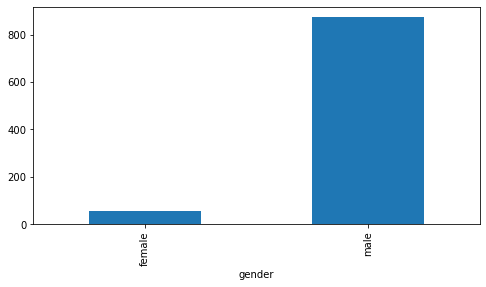

In [14]:
# kiválasszuk a nem kategóriát, ami így egy Series-hez vezet minket
by_gender = df.groupby('gender')

# a size()-al lekérjük számokban a kategóriákat,
# majd a plot()-al ábrázoljuk, meghatározva annak típusát, az oszlopot
by_gender.size().plot(kind='bar')

In [15]:
# létrehozzuk a csoportokat, kategória és nem szerint, tehát lesz az 6 kategória és 2 nem, összesen 12 csoport
by_cat_gen = df.groupby(['category', 'gender'])

# elérjük azt a csoportot, amely fizikából nyert Nobel-díjat és nő volt, majd kiválasztjuk azok nevét és az évet, amikor
# megnyerték
by_cat_gen.get_group(('Physics', 'female'))[['name', 'year']]

,name,year
32,Maria Goeppert-Mayer,1963
800,Marie Curie,1903
911,Donna Strickland,2018


In [18]:
by_cat_gen.size()

category                gender
Chemistry               female      5
                        male      180
Economics               female      2
                        male       82
Literature              female     15
                        male      100
Medicine                male        1
Peace                   female     17
                        male       90
Physics                 female      3
                        male      211
Physiology or Medicine  female     12
                        male      209
dtype: int64

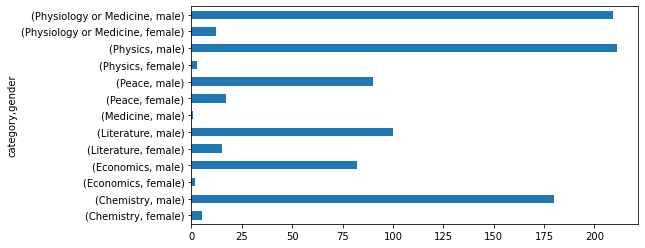

In [20]:
by_cat_gen.size().plot(kind='barh')

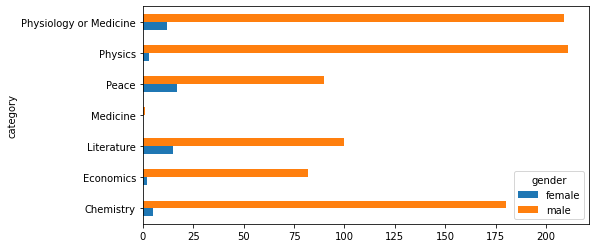

In [22]:
# létrehoz egy új DataFrame-t, amely esetében a megadott csoportok oszlopokká és indexekké válnak, a nemek jelenleg oszlopok
# és a kategóriák indexek
by_cat_gen.size().unstack()

# majd ezt az új DataFrame-t ábrázolhatjuk az előző módon
by_cat_gen.size().unstack().plot(kind='barh')

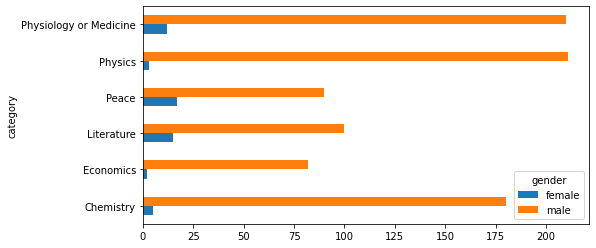

In [32]:
# elérjük azt a győztest, akinek kategóriája rosszul van írva
df[df.category == 'Medicine']
# érdekes, magyar az illető

# majd kijavítjuk a hibát és frissítjük az adatbázist
# és akár le is menthetjük javítva állományba is
df.loc[df.category == 'Medicine', 'category'] = 'Physiology or Medicine'

# mostmár üres
df[df.category == 'Medicine']

# le is ellenőrízhetjük a korábbi ábra megismétlésével

by_cat_gen = df.groupby(['category', 'gender'])
by_cat_gen.size().unstack().plot(kind='barh')
# eltűnt a Medicine kategória egyetlen férfi győztessel

def dataframe_mongo_compatible(df):
    # a MongoDB-n való tárolás miatt vissza kell alakítani object-é az oszlopot, és NaN-ra állítani a NaT-okat,
    # mert másképp nem engedi feltölteni, ValueError miatt
    df.date_of_death = df.date_of_death.astype(object).where(df.date_of_death.notnull(), np.nan)

    return df

def dataframe_reverse_compatible(df):
    # visszalakítjuk datetime objektummá az oszlopot
    df.date_of_death = pd.to_datetime(df.date_of_death)

    return df

df = dataframe_mongo_compatible(df)

# persze, ahhoz, hogy feltöltsük az idő oszlopokat Mongo kompatibilissá kell tennünk
dataframe_to_mongo(df, 'nobel_prize', 'winners_cleaned', forceupdate=True)

df = dataframe_reverse_compatible(df)

# lementjük JSON állományba is, ne felejtsük el a date_format-ot beállítani
df.to_json('winners_cleaned.json', orient='records', date_format='iso')

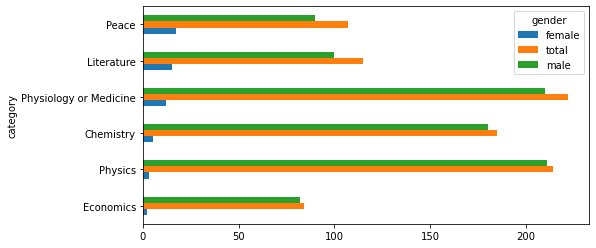

In [39]:
cat_gen_sz = by_cat_gen.size().unstack()

# oszlopok szerint summázuk, és létrehozunk egy 'total' új oszlopot
cat_gen_sz['total'] = cat_gen_sz.sum(axis=1) 

# a női oszlop szerint rendezzük
cat_gen_sz = cat_gen_sz.sort_values(by='female', ascending=True)

# képesek lehetnénk a lenti kiválasztás nélkül is ábrázolni,
# azonban így meghatározhatjuk az oszlopok egymás közötti sorrendjét
cat_gen_sz[['female', 'total', 'male']].plot(kind='barh')

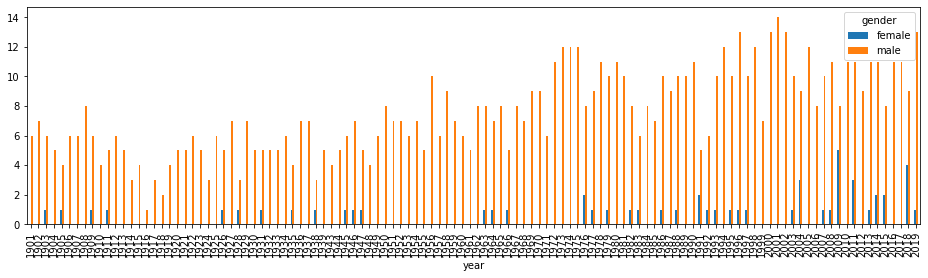

In [45]:
# létrehozzuk a csoportokat év és nem szerint
by_year_gender = df.groupby(['year', 'gender'])
# megszámoljuk, majd unstack-el létrehozzuk az új DataFrame-t
year_gen_sz = by_year_gender.size().unstack()
# ábrázoljuk oszlopdiagrammon
year_gen_sz.plot(kind='bar', figsize=(16, 4))

In [46]:
def thin_xticks(ax, tick_gap=10, rotation=45):
    """ Kitörli az x tengely címkéinek egy részét és elforgatja őket """
    
    # lekéri a jelenlegi címkéket pozícióját
    ticks = ax.xaxis.get_ticklocs()
    
    # megszerezzük a jelenlegi címkék szövegeit
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    
    # beállítsuk, a tick_gap szerinti lépegetéssel az új címkéket
    ax.xaxis.set_ticks(ticks[::tick_gap])
    
    # beállítsuk, a tick_gap szerinti lépegetéssel az új címkéket és elforgatja
    ax.xaxis.set_ticklabels(ticklabels[::tick_gap], rotation=rotation)

In [47]:
by_year_gender.size().unstack()

""" output:

gender	female	male
year		
1901	NaN	6.0
1902	NaN	7.0
1903	1.0	6.0
1904	NaN	5.0
1905	1.0	4.0
...	...	...
2015	2.0	8.0
2016	NaN	11.0
2017	NaN	11.0
2018	4.0	9.0
2019	1.0	13.0

"""

gender,female,male
year,,
1901,NaN,6.0
1902,NaN,7.0
1903,1.0,6.0
1904,NaN,5.0
1905,1.0,4.0
...,...,...
2015,2.0,8.0
2016,NaN,11.0
2017,NaN,11.0


In [51]:
# létrehozunk egy NumPy range-ből egy új Index-et 'year' névvel
new_index = pd.Index(np.arange(1901, 2020), name='year')
# létrehozzuk a megszokott csoportokat
by_year_gender = df.groupby(['year', 'gender'])
# létrehozzuk az új csoportok szerinti DataFrame-t a size-ból, és ellássuk az új index-el, amely 1901-től 2019-ig megy
year_gen_sz = by_year_gender.size().unstack().reindex(new_index)

gender,female,male
year,,
1901,NaN,6.0
1902,NaN,7.0
1903,1.0,6.0
1904,NaN,5.0
1905,1.0,4.0
...,...,...
2015,2.0,8.0
2016,NaN,11.0
2017,NaN,11.0


Text(0.5, 0, 'Year')

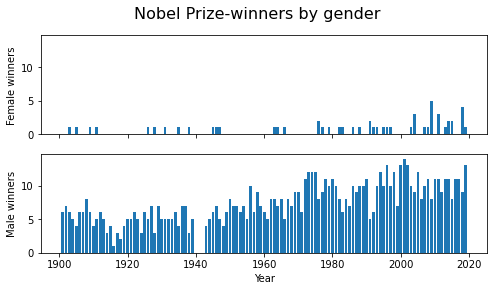

In [58]:
# létrehozzuk a subplot rendszerünket, 1 oszloppal és 2 sorral, valamint megosztott x és y tengelyekkel a normalizáltság miatt
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)

# kiválasztjuk hol legyen a férfi és női ábra
ax_f = axes[0]
ax_m = axes[1]

# címet adunk a figure-nak
fig.suptitle('Nobel Prize-winners by gender', fontsize=16)

# létrehozzuk a felső, női győzteseket bemutató oszlopdiagrammot, x érték az évek, y érték a nyertesek számai
ax_f.bar(year_gen_sz.index, year_gen_sz.female)
ax_f.set_ylabel('Female winners')

# ugyanúgy férfi esetén is
ax_m.bar(year_gen_sz.index, year_gen_sz.male)
ax_m.set_ylabel('Male winners')

# majd az alsó ábra esetén x tengelycímkét is beállítunk, felső esetén fölösleges
ax_m.set_xlabel('Year')

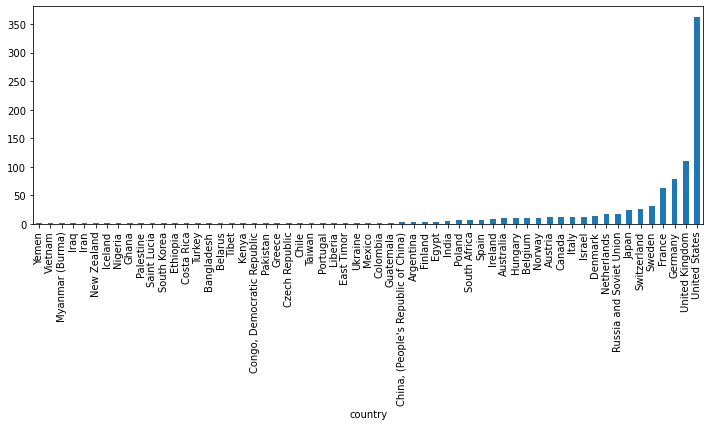

In [62]:
df.groupby('country').size().sort_values(ascending=True).plot(kind='bar', figsize=(12, 4))

In [67]:
nat_group = df.groupby('country')
ngsz = nat_group.size() # kiírja indexként az országot, oszlopértékben pedig, hogy hány győztese van

df_countries = mongo_to_dataframe('nobel_prize', 'country_data') # elérjük a lementett országadatainkat
df_countries.head()

,name,topLevelDomain,alpha2Code,alpha3Code,callingCodes,capital,altSpellings,region,subregion,population,...,area,gini,timezones,borders,nativeName,numericCode,currencies,languages,translations,relevance
0,Afghanistan,[.af],AF,AFG,[93],Kabul,"[AF, Afġānistān]",Asia,Southern Asia,26023100,...,652230.0,27.8,[UTC+04:30],"[IRN, PAK, TKM, UZB, TJK, CHN]",افغانستان,004,[AFN],"[ps, uz, tk]","{'de': 'Afghanistan', 'es': 'Afganistán', 'fr'...",0
1,Åland Islands,[.ax],AX,ALA,[358],Mariehamn,"[AX, Aaland, Aland, Ahvenanmaa]",Europe,Northern Europe,28875,...,1580.0,NaN,[UTC+02:00],[],Åland,248,[EUR],[sv],"{'de': 'Åland', 'es': 'Alandia', 'fr': 'Åland'...",0
2,Albania,[.al],AL,ALB,[355],Tirana,"[AL, Shqipëri, Shqipëria, Shqipnia]",Europe,Southern Europe,2893005,...,28748.0,34.5,[UTC+01:00],"[MNE, GRC, MKD, KOS]",Shqipëria,008,[ALL],[sq],"{'de': 'Albanien', 'es': 'Albania', 'fr': 'Alb...",0
3,Algeria,[.dz],DZ,DZA,[213],Algiers,"[DZ, Dzayer, Algérie]",Africa,Northern Africa,39500000,...,2381741.0,35.3,[UTC+01:00],"[TUN, LBY, NER, ESH, MRT, MLI, MAR]",الجزائر,012,[DZD],[ar],"{'de': 'Algerien', 'es': 'Argelia', 'fr': 'Alg...",0
4,American Samoa,[.as],AS,ASM,[1684],Pago Pago,"[AS, Amerika Sāmoa, Amelika Sāmoa, Sāmoa Amelika]",Oceania,Polynesia,55519,...,199.0,NaN,[UTC-11:00],[],American Samoa,016,[USD],"[en, sm]","{'de': 'Amerikanisch-Samoa', 'es': 'Samoa Amer...",0.5


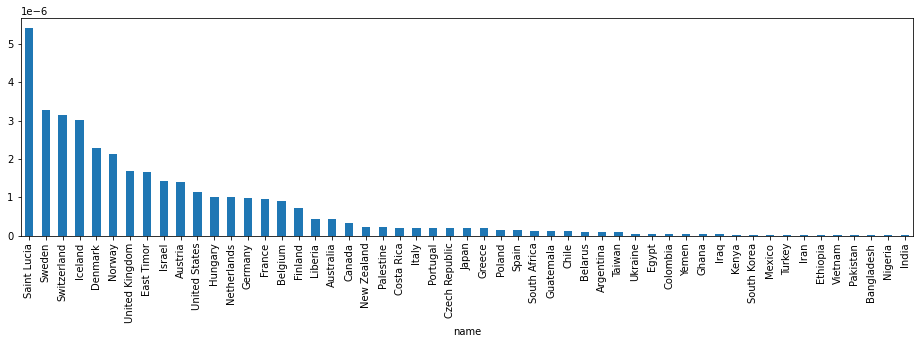

In [81]:
# beállítjuk az új indexet, az egész számú indexelésről, a 'name' oszlopra
# df_countries = df_countries.set_index('name')
# hozzáadjuk az új oszlopot, amely az összevonódik a megosztott indexek miatt
df_countries['nobel_wins'] = ngsz
# hozzáadjuk az új oszlopot, felhasználva már két létező oszlopot
df_countries['nobel_wins_per_capita'] = df_countries['nobel_wins'] / df_countries['population']

# kitöröljük azokat az országokat a letöltött adatainkból, ahol nem volt Nobel-győztes
df_countries = df_countries[df_countries.nobel_wins_per_capita.notnull()]

# mostmár ábrázolhatjuk a relatív győzteseket
df_countries.sort_values(by='nobel_wins_per_capita', ascending=False).nobel_wins_per_capita.plot(kind='bar', figsize=(16, 4))

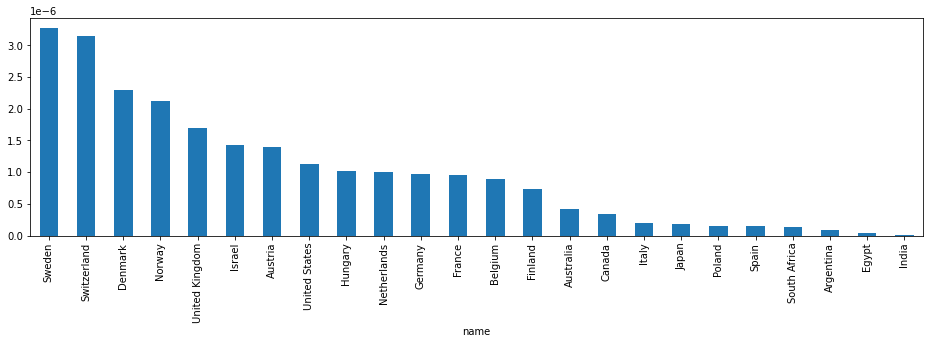

In [84]:
df_countries[df_countries.nobel_wins > 2]\
    .sort_values(by='nobel_wins_per_capita', ascending=False).nobel_wins_per_capita.plot(kind='bar', figsize=(16, 4))

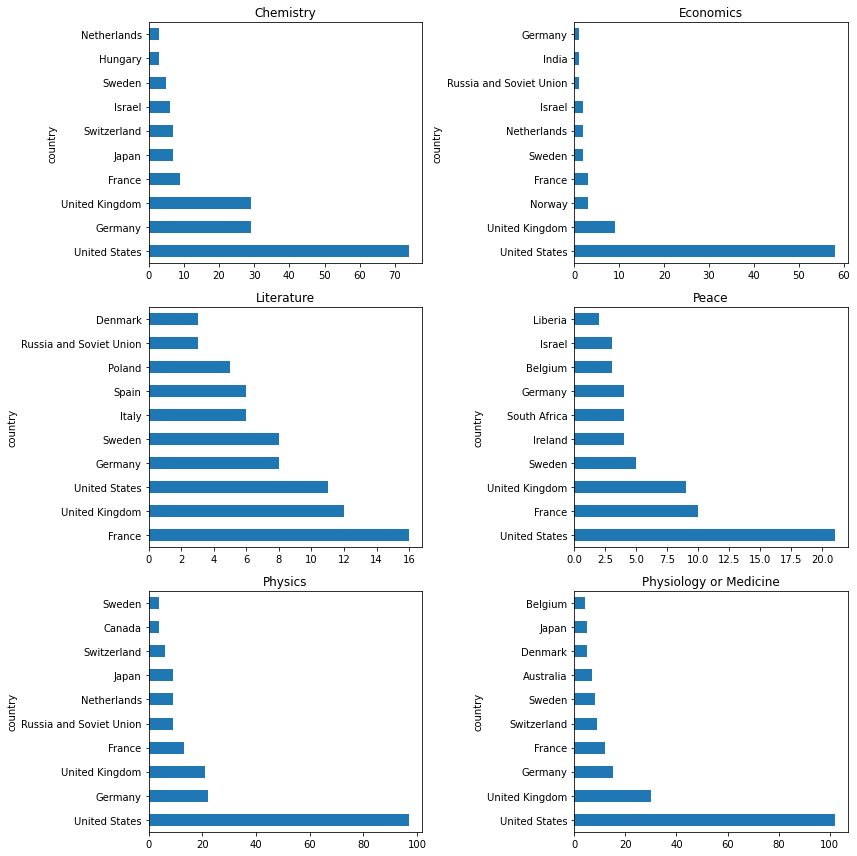

In [101]:
nat_cat_sz = df.groupby(['country', 'category']).size().unstack()
nat_cat_sz # indexelve az ország szerint, oszlopozva kategória szerint,
            # így arról is kapunk információt, hogy melyik ország nem nyert melyik kategóriába Nobel-t, de másban igen
    
COL_NUM = 2
ROW_NUM = 3
# 6 díjtípus van összesen

fig, axes = plt.subplots(nrows=ROW_NUM, ncols=COL_NUM, figsize=(12, 12))

for i, (label, col) in enumerate(nat_cat_sz.iteritems()):
    ax = axes[i // COL_NUM, i % COL_NUM]
    col = col.sort_values(ascending=False, inplace=False)[:10]
    col.plot(kind='barh', ax=ax)
    ax.set_title(label)
    
plt.tight_layout()
fig.savefig('fig48.png')

In [ ]:
plt.rcParams['font.size'] = 20

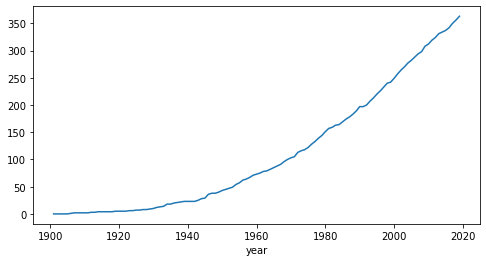

In [106]:
# létrehozzuk az új indexeket
new_index = pd.Index(np.arange(1901, 2020), name='year')

# létrehozzuk a csoportokat, év és ország szerint, majd létrehozzuk unstackelés után az új DataFrame-t
# végül hozzárendeljük az új indexeket, mostmár az összes évvel
by_year_nat_sz = df.groupby(['year', 'country']).size().unstack().reindex(new_index)

# már képesek is vagyunk ábrázolni
# a fillna(0) segítségével, azokat az éveket, amikor nem volt amerikai Nobel-díj győztes 0-val tölti ki, így
# megelőzve, hogy szakaszos legyen a vonalábránk
by_year_nat_sz['United States'].fillna(0).cumsum().plot()
plt.savefig('fig49.png')

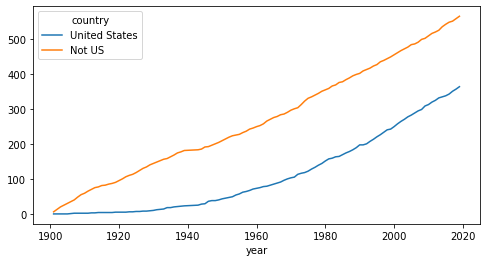

In [111]:
by_year_nat_sz = df.groupby(['year', 'country']).size().unstack().fillna(0)

# létrehoz egy listát az országnevekből, majd kitörli az AEÁ-t
not_US = by_year_nat_sz.columns.tolist()
not_US.remove('United States')

# hozzáfűz egy új oszlopot a DateFrame-hez, amely az AEÁ kivételével minden ország győzelmeinek összege
by_year_nat_sz['Not US'] = by_year_nat_sz[not_US].sum(axis=1)

# majd ábrázoljuk, csakis ezt a két csoportot kiválasztva
ax = by_year_nat_sz[['United States', 'Not US']].cumsum().plot()

plt.savefig('../img/fig50.png')

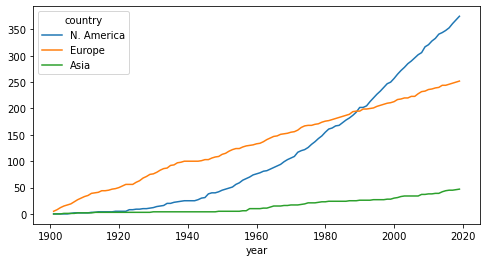

In [130]:
new_index = pd.Index(np.arange(1901, 2020), name='year')

by_year_nat_sz = df.groupby(['year', 'country']).size().unstack().reindex(new_index).fillna(0)

regions = [
    {'label': 'N. America', 'countries': ['United States', 'Canada']},
    {'label': 'Europe', 'countries': ['Germany', 'France', 'United Kingdom']},
    {'label': 'Asia', 'countries': ['Japan', 'India', 'Russia and Soviet Union']}
]

for region in regions:
    by_year_nat_sz[region['label']] = by_year_nat_sz[region['countries']].sum(axis=1)
    
by_year_nat_sz[['N. America', 'Europe', 'Asia']].cumsum().plot()

plt.savefig('../img/fig51.png')

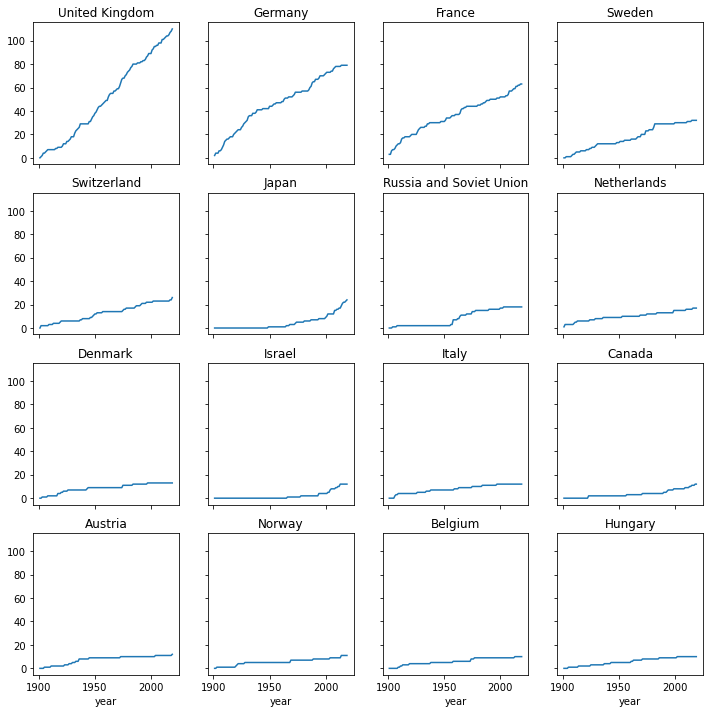

In [135]:
COL_NUM = 4
ROW_NUM = 4

by_nat_sz = df.groupby(['country']).size()

by_nat_sz.sort_values(ascending=False, inplace=True)

fig, axes = plt.subplots(nrows=ROW_NUM, ncols=COL_NUM, sharex=True, sharey=True, figsize=(12, 12))

# kihagyjuk az első sort, hiszen az az AEÁ
for i, nat in enumerate(by_nat_sz.index[1:17]):
    ax = axes[i // COL_NUM, i % ROW_NUM]
    by_year_nat_sz[nat].cumsum().plot(ax=ax)
    ax.set_title(nat)
    
plt.savefig('../img/fig52.png')

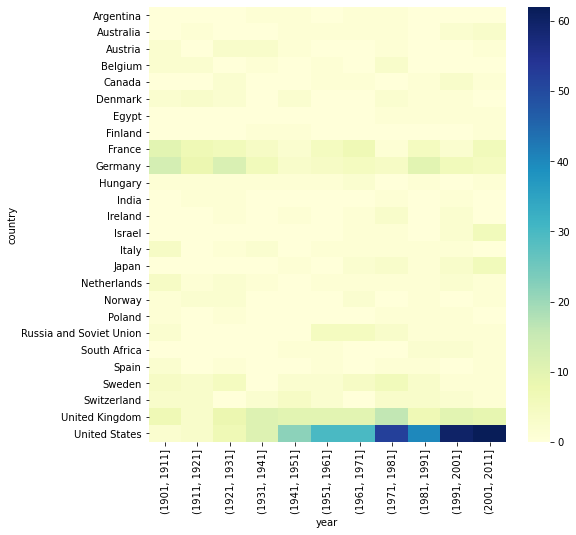

In [140]:
# létrehozzuk a bineket, felosztva 10 évente, (1901, 1911, 1921, ...)
bins = np.arange(df.year.min(), df.year.max(), 10)

# használjuk a cut metódust és létrehozzuk a csoportokat
by_year_nat_binned = df.groupby(['country', pd.cut(df.year, bins, precision=0)]).size().unstack().fillna(0)

plt.figure(figsize=(8, 8))

# megszerkesztjük a heatmap-et azokra az országokra pontosítva, ahol legalább 2 Nobel nyertes volt
sb.heatmap(by_year_nat_binned[by_year_nat_binned.sum(axis=1) > 2], cmap="YlGnBu")

plt.savefig('../img/fig53.png')